<a href="https://colab.research.google.com/github/DasBlaueWunder/Homeworx/blob/main/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4

## Malaria detection

The target of this homework is to detect, which cells are infected with malaria with a Convolutional Neural network (CNN). Therefore preclassified images of cells with a binary classification can be used to train a model.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
def show_examples(dataset, number):
  for i,(image, label) in enumerate(dataset.take(number)):
    title = "Example " + str(i) + ": Shape = "+ str(image.shape) + ", Label = " + str(label.numpy())
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.show()

### 1. Load data set and preprocess

Load the data set and explore.
The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.

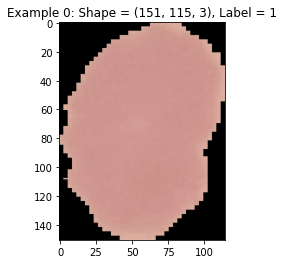

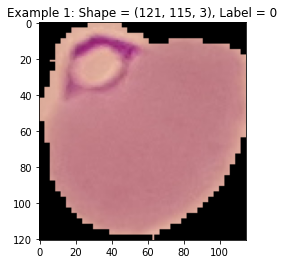

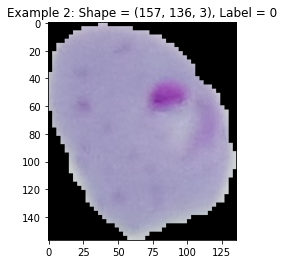

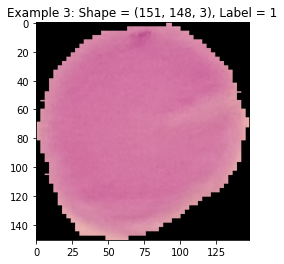

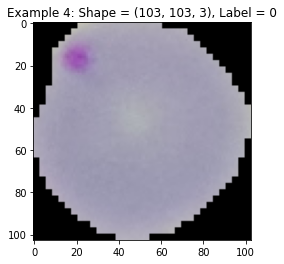

In [ ]:
# Load train and test data set as shuffled subsets of the malaria data set - Data split at 80% (22,046 images for training, 5,512 for testing)
train_dataset, test_dataset = tfds.load('malaria', as_supervised=True, split = ['train[:80%]', 'train[80%:]'], shuffle_files = True) # we take the full data set
assert isinstance(dataset, tf.data.Dataset)

# Show some examples
show_examples(train_dataset, 5)

### Preprocessing

We observe that the image shapes differ from each other. Unfortunately CNNs work best, if all images have the same quadratic size, so that the main objects are in a similar region in each of the images. Therefore we have to resize the images to a quadratic shape with the size of the smallest image. (from lecture 4.2 > Image representation > Image representation).
128x128px seemed to be a good fit (the example 4 occured in a re-run after the time consuming training has been finished).

To retrieve a better result, we normalize the data and one-hotify the labels.

Furthermore, we make use of mini-batches of the size 100 to get a better approximation of the "real" gradient over the whole data set. (see 4.1 Optimization Techniques I > Batching, why?)

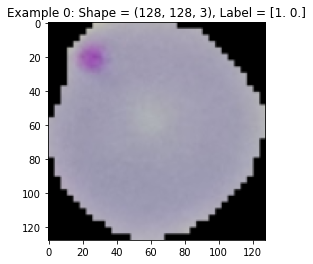

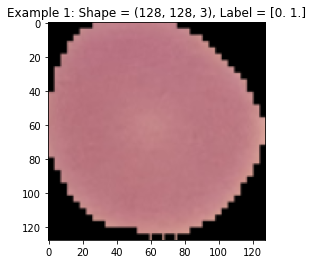

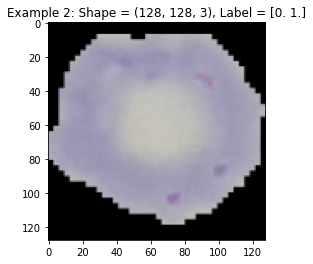

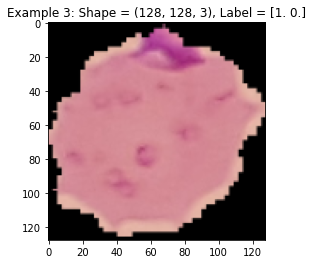

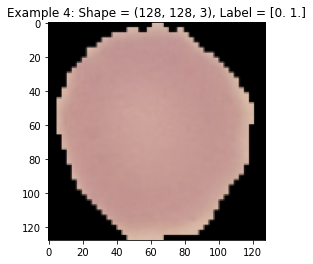

In [ ]:
# Resize the image, normalize it and use One-hot-encoding for the labels for better results
def preprocess(dataset):
  dataset = dataset.map(lambda image, label: (tf.image.resize_with_pad(image/255, 128, 128),tf.one_hot(label,2))) # 128 seems to be a lower bound of the size on each axis
  return dataset

train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)

# Show some examples (just to control, if everything has been done correctly)
show_examples(train_dataset, 5)

# Batching and fetching
# Another shuffle (buffer_size should be greater equal data set size)
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(100).prefetch(1)
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(10).prefetch(1)

## 2. Model

In this week, we want to try Convolutional Neural Networks (CNNs).
Just like the "normal" neural network, such a CNN consists of some layers with each being made of neurons, but instead of having a matrix vector product, we are going to use convolutions as the linear function of our input data (which does not necessarily be a vector). At the edges, we are going to fill the edges with zeros ("same padding").

Hence, we have to learn the parameters of the convolution kernel (4.2 Convolutional layer > Convolutional layer) in each Convolutional layer. Nevertheless, we are allowed to use fully-connected layers in our CNN, too. (https://cs231n.github.io/convolutional-networks/)

Furthermore we make use of Max-Pooling with a pool size of 2x2. With this, our tensors will shrink in size, so the network has to learn less parameters and finish faster. (4.2 Convolutional layer > Pooling Layer).

Hence, we use a network like:

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # First hidden layer: Convolutional layer with 64 filters and 3x3 kernel size
        self.conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                                               activation=tf.keras.activations.relu)
        # followed by Max-Pooling layer to reduce the parameter size,...
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same',
                                               strides=(2,2), activation=tf.keras.activations.relu)
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding='same',
                                               strides=(3,3), activation=tf.keras.activations.relu)
        self.max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        # shrink the tensors with Global Average Pooling
        # (4.2 Convolutional layer > Pooling layer > Pooling layer)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        # Last part of our network: A common fully-connected neural network (from last week)
        self.dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)
        self.dense_2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)
        # output dense layer with the size of the labels
        self.output_layer = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)

    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        # No worries about input size, Keras does that for you
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.global_pool(x)
        x = self.dense_1(x)
        x = self.dense_2 (x)
        x = self.output_layer(x)
        return x

## 3. Training
Train with Adam for 10 epochs with a learning rate of 0.001, while the loss is categorical cross entropy.

The training is really time consuming, the result below took 2 hours to finish.


In [ ]:
# The training is the same as last week

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = Model()
# Initialize the loss for binary classification
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=1000)
    test_dataset = test_dataset.shuffle(buffer_size=1000)

    #training (and checking in with training)
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
    train_losses.append(train_loss)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


## 4. Visualization
Visualize both accuracy and loss for training and test data.

While time consuming (took about 2hrs), the network works pretty well and classifies >95% of the test data (20% of the whole data set) correctly.

Nevertheless, with just 9% of the data set as train data, the network achieved >93% accuracy in way less time (approx. 15min).

(Since it took so long to train the model and we were quite lucky with the first try, we have not tried any other architectures)

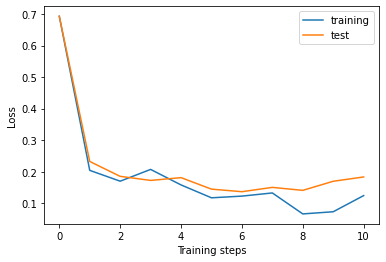

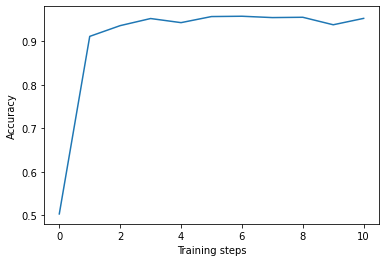

Accuracy: 0.9521739130434783


In [ ]:
%matplotlib inline

# Loss (in one plot)
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Accuracy
plt.figure()
plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

print('Accuracy: '+ str(test_accuracies[-1]))

With 9% training data and 10% test data split of the malaria dataset as well as 10 epochs, we got this result (which is slightly worse, but ran way shorter):

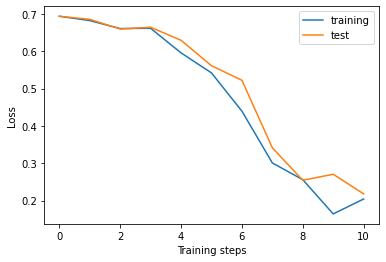

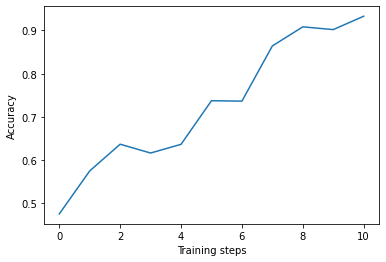

Accuracy: 0.9329710144927537


In [ ]:
%matplotlib inline

# Loss (in one plot)
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Accuracy
plt.figure()
plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

print('Accuracy: '+ str(max(test_accuracies)))